In [1]:
# Custom classes
from pandasgui import show
from Library.DFInfo import DataFrameInfo
from Library.db_util import RDSDatabaseConnector
from Library.GraphPlotter import Plotter
from Library.DFTransform import DataFrameTransform
from Library.DTransform import DataTransform
from Library.DFInsights import Insights

# modules
import warnings, os
import pandas as pd

# to stop spam of deprecated feature
warnings.simplefilter(action="ignore", category=FutureWarning) 

#creates all the classes
rdsdbc = RDSDatabaseConnector()
dtransformer = DataTransform()
dfinfo = DataFrameInfo()
dftransformer = DataFrameTransform()
plotter = Plotter()
insights = Insights()

available_list = ["policy_code"]
string_list = ["policy_code", "term"]
strip_list = ["term"]
qualitative_list = ["purpose", "grade", "sub_grade","home_ownership", "verification_status", "loan_status", "payment_plan", "application_type", "employment_length"]
outlier_columns = ["funded_amount", "funded_amount_inv", "installment", "open_accounts", "delinq_2yrs", "total_accounts", "total_payment", "total_payment_inv", "total_rec_prncp", "total_rec_int", "last_payment_amount"]
ignore_transform_list = ["funded_amount", "funded_amount_inv"]

dtransformer.set_available_list(available_list)
dtransformer.set_string_list(string_list)
dtransformer.set_strip_list(strip_list)
dtransformer.set_qualitative_list(qualitative_list)

file_path = "script_data/loan_payments.csv"

try:
    dataframe = pd.read_csv(file_path)
    print("loaded from file")
except:
    dataframe = rdsdbc.download_df()
    print("downloaded dataframe")


loaded from file


We will use our ```dfinfo``` Module to get all relevant information on this dataset. From there, we can see what needs to be done.

In [2]:
pd.set_option("display.width", 200)
pd.set_option("display.max_columns", 2000)
dfinfo.call_all_information(dataframe)

                             Count          Mean       Min           Max  Standard Deviation      Median                Mode  Null Percentages  Distinct_Values_Count
id                           54231  7.621797e+06  55521.00  3.867612e+07        9.571362e+06  7084590.00               55521          0.000000                  54231
member_id                    54231  8.655350e+06  70694.00  4.146185e+07        1.031281e+07  8709873.00               70694          0.000000                  54231
loan_amount                  54231  1.333308e+04    500.00  3.500000e+04        8.082197e+03    12000.00             10000.0          0.000000                   1083
funded_amount                51224  1.322951e+04    500.00  3.500000e+04        8.019018e+03    12000.00             10000.0          5.544799                   1122
funded_amount_inv            54231  1.295262e+04      0.00  3.500000e+04        8.099474e+03    11300.00             10000.0          0.000000                   5261
term

from the information provided above, several key points can be identified.

* All columns where the mean/min/max/std/median are ```NaN```are columns where they arent automatically integers. this can be changed by either removing all non integer characters, or placing the values into categories. For example ```36 months``` in ```term``` is obviously meant to just display the value ```36```, so we can perform numerical analysis on this. We can clean this by removing all the redundant strings and convert the column to ```int```. Whereas ```MORTGAGE``` in ```home_ownership``` cannot be represented by a number. Here we want to set the column to a categorical dtype.

* We can see that a few columns have ```NaN``` values, some with more than 50%. Columns with ```NaN``` values makes doing data analysis very hard for us, so we will want to either ```Impute``` our data or ```Drop``` the column entirely if there isnt enough data to reliably impute.

* Columns with large ```standard deviations``` means there can be alot of outliers, which make our analysis less reliable. We will need to remove these outliers, and we can use the deviation to guide us on which columns might have alot of outliers.

In [3]:
dataframe = dtransformer.call_all_cleaners(dataframe)

```dtransformer.call_all_cleaners()``` sets all columns to their correct dtype for faster code execution using the mutliple lists above

Columns with skewness greater than 5 are: ['annual_inc', 'delinq_2yrs', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med']


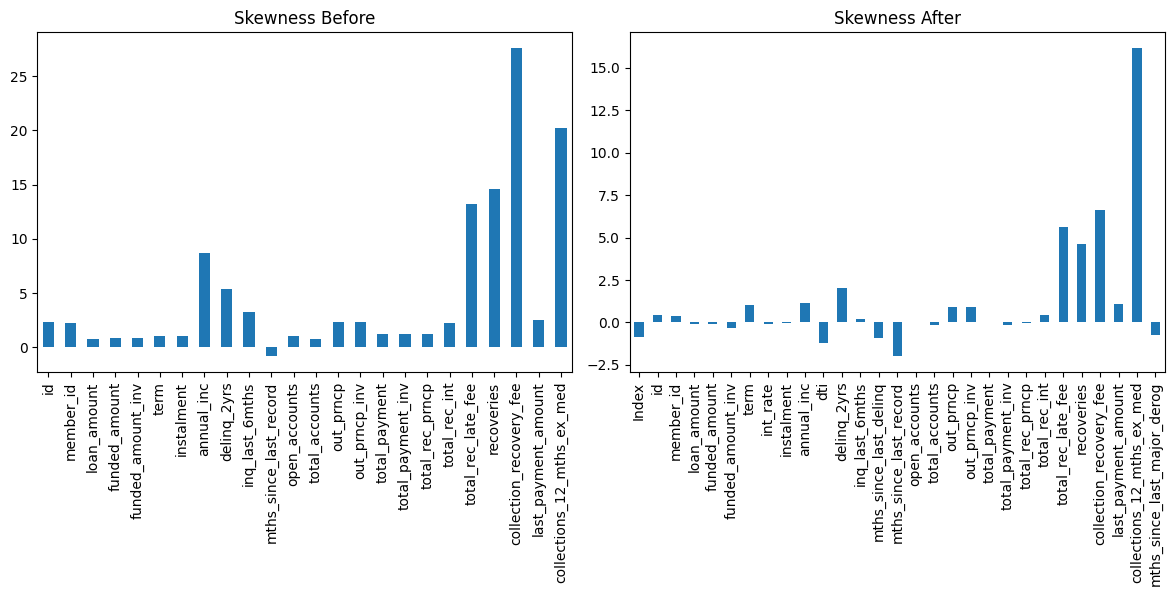

In [4]:
skewed_columns = dtransformer.get_skewed_columns(dataframe, qualitative_list, 0.5)
skewed_dataframe, median_list = dtransformer.get_skewed_dataframe(dataframe, skewed_columns)
unskewed_dataframe, transformation_methods = dftransformer.remove_skewness(dataframe, qualitative_list)
plotter.plot_skewed_vs_unskewed_graph(skewed_dataframe.skew(), unskewed_dataframe.skew())



In [5]:
print(f"These are all the transformation methods done on each column: \n \n{transformation_methods}")

These are all the transformation methods done on each column: 
 
Transformed column 'Index'using transformation method: None,  
Transformed column 'id'using transformation method: log,  
Transformed column 'member_id'using transformation method: log,  
Transformed column 'loan_amount'using transformation method: cbrt,  
Transformed column 'funded_amount'using transformation method: cbrt,  
Transformed column 'funded_amount_inv'using transformation method: sqrt,  
Transformed column 'term'using transformation method: cbrt,  
Transformed column 'int_rate'using transformation method: sqrt,  
Transformed column 'instalment'using transformation method: cbrt,  
Transformed column 'annual_inc'using transformation method: log,  
Transformed column 'dti'using transformation method: None,  
Transformed column 'delinq_2yrs'using transformation method: cbrt,  
Transformed column 'inq_last_6mths'using transformation method: cbrt,  
Transformed column 'mths_since_last_delinq'using transformation met

from this function above, we can see ```collection_recovery_fee```, ```collections_12_mths_ex_med```, ```recoveries```, ```total_rec_late_fee```, ```annual_inc``` and ```delinq_2yrs``` are all positively skewed by more than a value of 5. When imputing data, I will impute these columns with the median instead of the mean.

Dropping columns as the amount of nulls in the column is above 50.0%: 
 ['employment_length', 'mths_since_last_delinq', 'mths_since_last_record', 'next_payment_date', 'mths_since_last_major_derog']


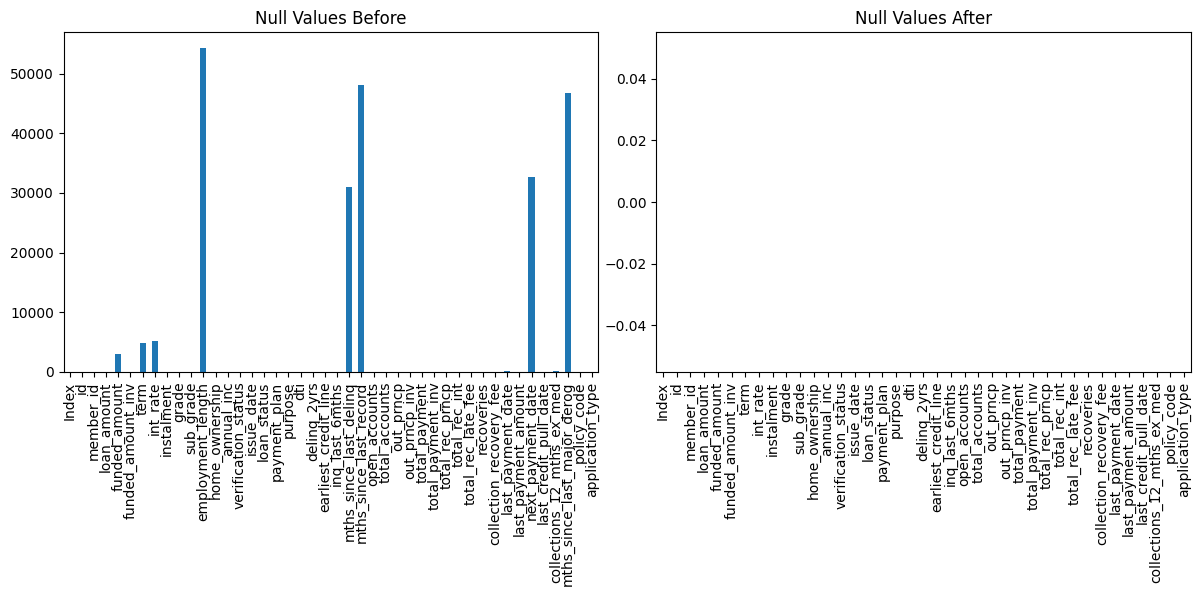

In [6]:
#calls the plotter and visualises the null value removal
nulls_before = dftransformer.count_nulls(dataframe)
dataframe = dftransformer.drop_columns(dataframe, 0.5)
dataframe = dftransformer.impute_columns(dataframe, median_list)
nulls_after = dftransformer.count_nulls(dataframe)

insight_dataframe = dataframe
dataframe = unskewed_dataframe

plotter.plot_nulls_before_after(nulls_before, nulls_after)

Dropped ```mths_since_last_delinq```, ```mths_since_last_record``` and ```mths_since_last_major_derog```, as their null value % was above 50%. This makes imputing data very difficult and unreliable since there isnt enough data in these columns to "guess" the null values. Using ML can possibly be more accurate and account for this, however uses alot of computational power.

In [7]:
combined_df = dftransformer.merge_dataframes(dataframe, unskewed_dataframe)
combined_df.to_csv(os.path.join("script_data", "combined_dataframe.csv"), index=False)

plotter.visualise_outliers(dataframe, outlier_columns, False)
before = dataframe
drop_outlier_dictionary = dftransformer.find_closest_outliers(dataframe, outlier_columns)
dataframe = dftransformer.drop_outside_bounds(dataframe, drop_outlier_dictionary)
after = dataframe

{'funded_amount': [8.512158656176283, 36.824567113636576], 'funded_amount_inv': [7.818969862391205, 37.240480389907624], 'delinq_2yrs': [0.0, 0.0], 'open_accounts': [1.2553259253498363, 3.0089399451433105], 'total_accounts': [1.5875342708872762, 4.073688481293863], 'total_payment': [7.150062726090621, 36.2554496398983], 'total_payment_inv': [6.770267800967794, 36.23682559804519], 'total_rec_prncp': [5.7220788717360005, 33.705403523686186], 'total_rec_int': [1.6614133289844295, 22.881649027898078], 'last_payment_amount': [-6.731594502251353, 28.870273365155533]}


In [8]:
count_before = dftransformer.calculate_outlier_counts(before, outlier_columns)
count_after = dftransformer.calculate_outlier_counts(after, outlier_columns)
before_dataframe = pd.DataFrame(data = count_before, index = [0])
after_dataframe = pd.DataFrame(data = count_after, index = [0])

columns where I deemed the outliers to be irrelevent to analysing and viewing the dataset as a whole.

```funded_amount/inv``` because there are so little, and too far from median.
```open/total_accounts``` because it is odd to have 0 accounts open.
outliers above 5 in ```open_accounts``` seem irrelevent to me as there are so little of them.
```delinq_2yrs``` because they are so far from the only value.
```total_payment/inv``` because the values are too from the median.
```last_payment_amount``` as the values are too scattered below the lower bounds.

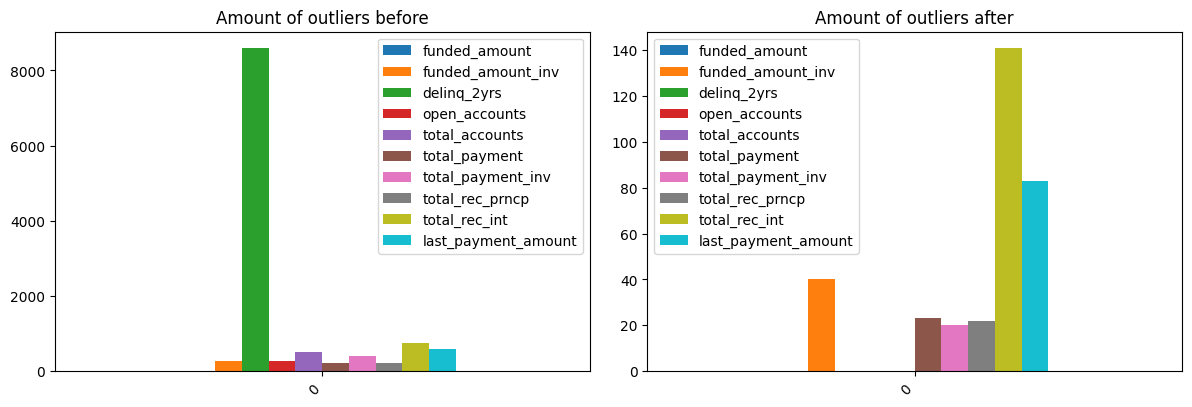

In [9]:
plotter.plot_outliers_before_after(before_dataframe, after_dataframe)

Columns dropped:['id', 'member_id', 'delinq_2yrs', 'funded_amount', 'funded_amount_inv', 'instalment', 'total_payment', 'total_payment_inv', 'total_rec_int', 'mths_since_last_major_derog', 'out_prncp_inv', 'collection_recovery_fee']


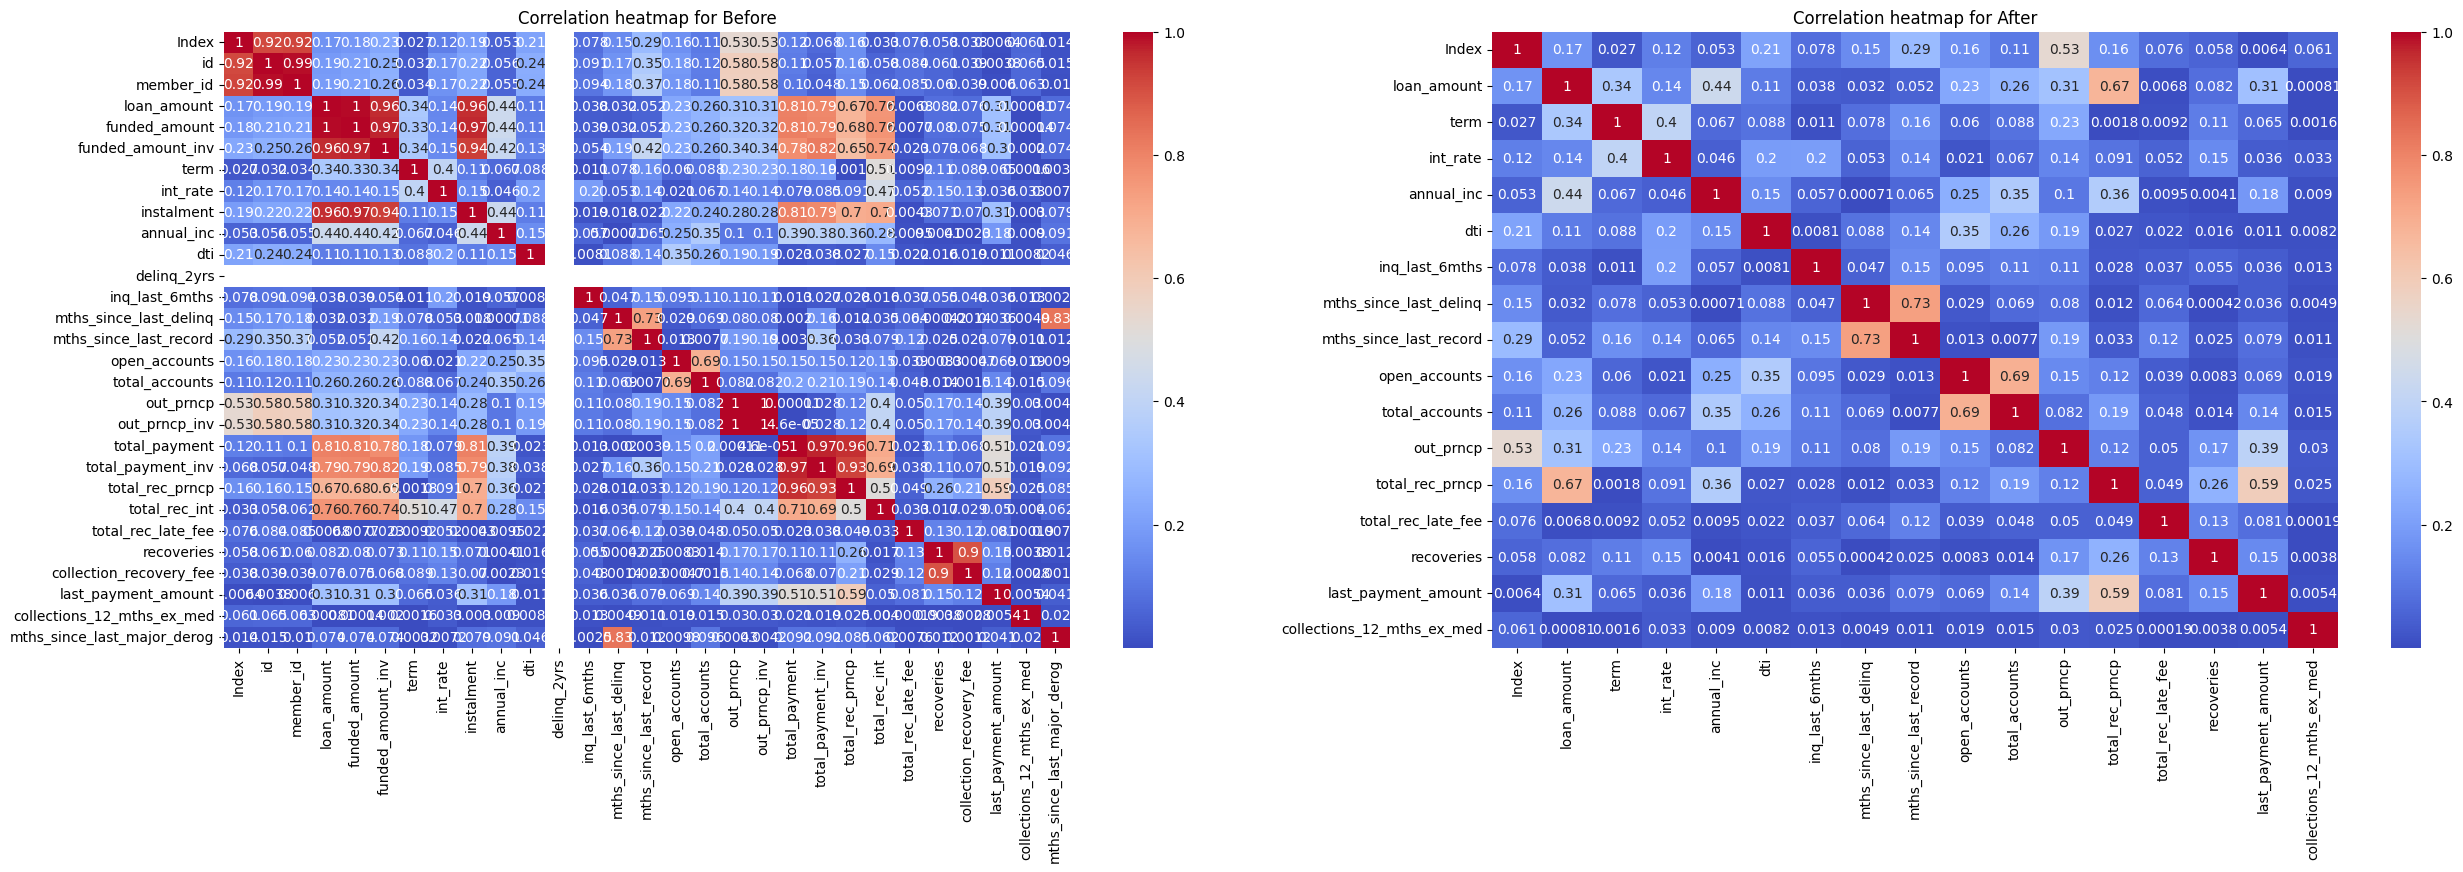

In [10]:
matrix_before = dftransformer.get_correlation_matrix(dataframe)
dataframe = dftransformer.drop_overcorrelated(dataframe, matrix_before, threshold=0.75)
matrix_after = dftransformer.get_correlation_matrix(dataframe)
plotter.plot_correlation_before_after(matrix_before, matrix_after)

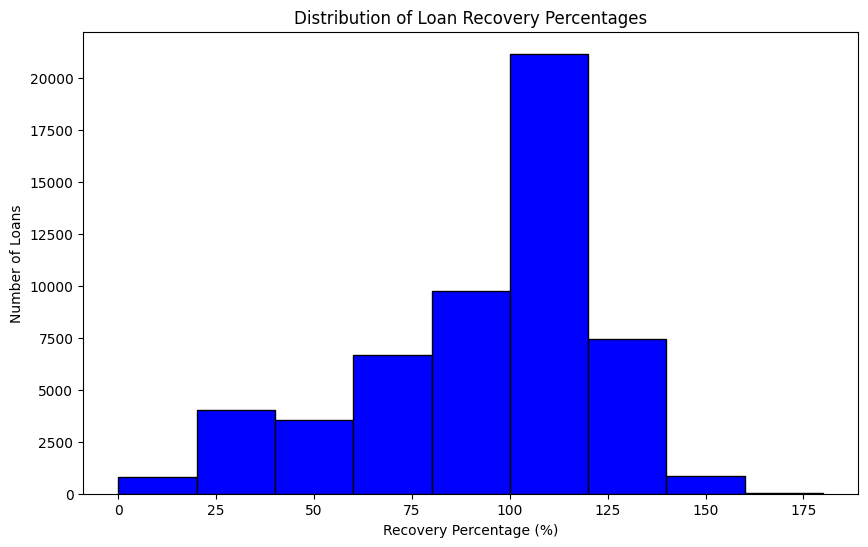

In [11]:
loans_recovery_percentage, loans_percentage_to_pay, projected_payment_6mths = insights.visualise_repayments(insight_dataframe)

plotter.plot_recovery_rate(loans_recovery_percentage)
        
        

The graph above shows the recovery percentage of each loan, and how much has been retreived. In the case where the recovery percentage is above 100%, the repayment amount exceeds the loan amount withdrawn. this is due to interest rates and late payments, increasing how much needs to be payed back.

Here we can see most payments have been payed back, and has gained profit from interest rates.

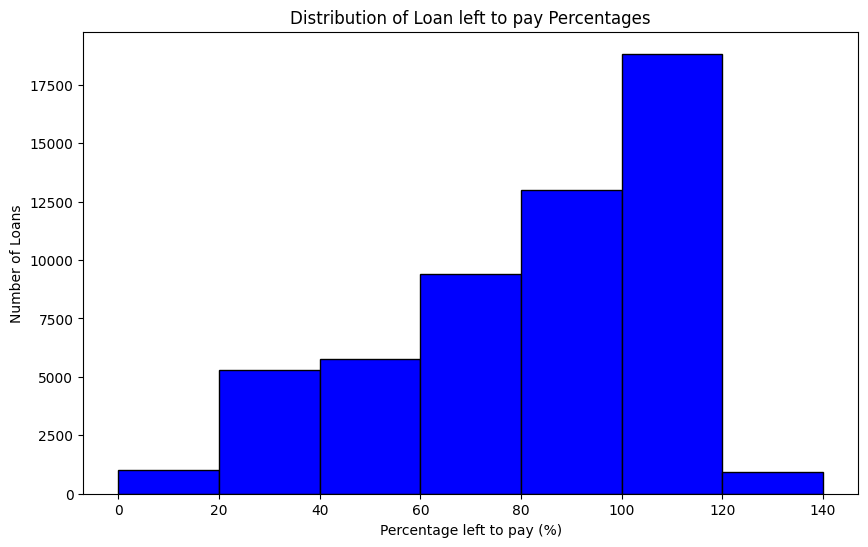

In [12]:
plotter.plot_loan_to_pay(loans_percentage_to_pay)

The above graph shows us that most loans have just started, and less than 1000 loans are almost (80%-100% paid off) completely paid off. When % left to pay is above 100%, this includes interest rate from the loan.

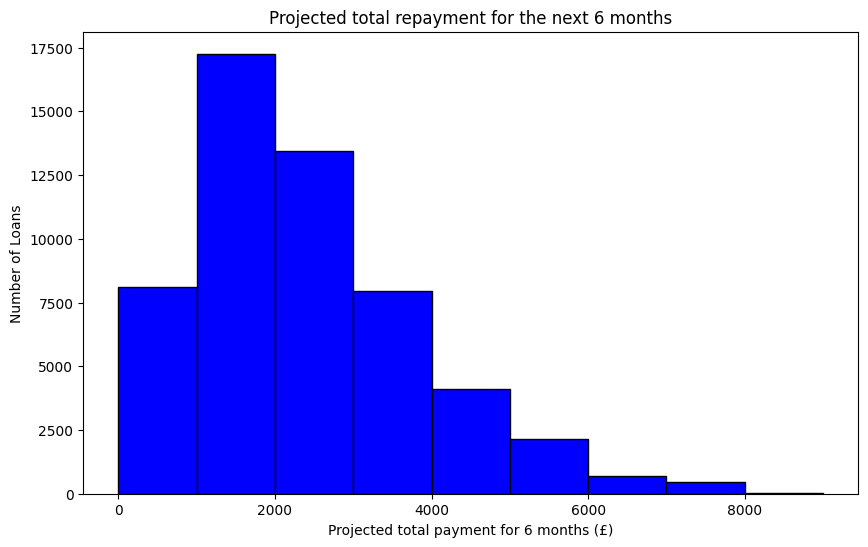

In [13]:
plotter.plot_amount_payed_6mths(projected_payment_6mths)

Percentage of Charged Off Loans: 10.273%
Total amount paid towards charged off loans: £37400589


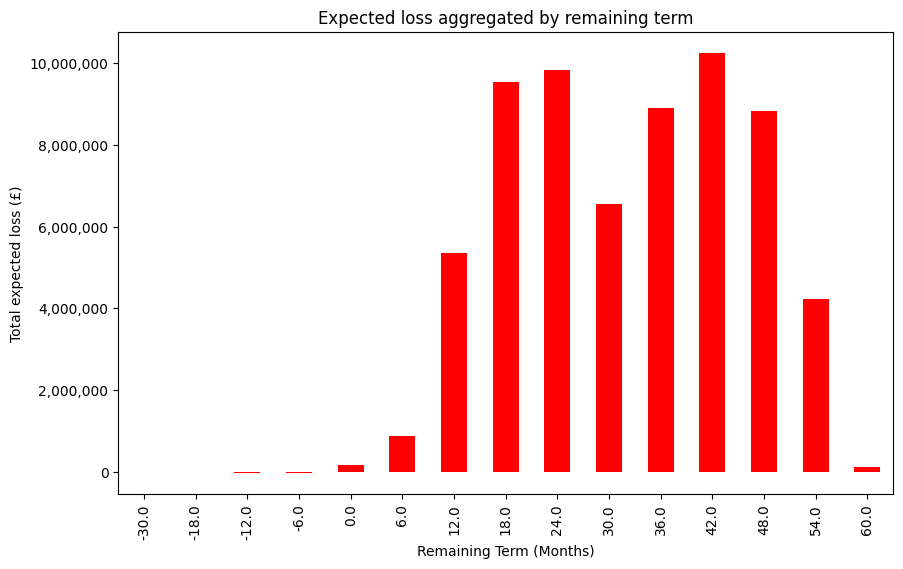

In [14]:
insights.visualise_loss(insight_dataframe)

This shows expected loss if all loans classed as ```Charged Off``` had finished their terms. Where ```Remaining Term``` is negative, this is where the loan has extended past its expected term length

In [15]:
insights.visualise_potential_loss(insight_dataframe)

1.3608452729988383% of all customers are late on their payments.
There are 738 people late on their payments. A total of £67998454 would be lost if they were set to Charged Off
The average expected loss per person is £92138.82655826559
If customers were to finish their term, the projected loss would be £272602472
Late and Defaulted payments represent 0.0164413065874623% of all revenue


Sub grades have a direct correlation with loans being Charged off, and this extends to all late payments, as the grades with high charged off rates, also have high late payment rates
The same goes with the home ownership status. If you rent or pay mortgage on your home, the loan is likely to end up Charged Off.
The loan purpose also has a correlation, albeit less impactful. Home improvements, debt consolidation, credit cards or others seem to be a high risk loan, as these are likely to be charged off. Being late on the loans will likely end up being CHarged off too
Having a shorter term length will result in being more likely to be charged off, however the term length doesnt seem to be affected by wether you are late on the loan

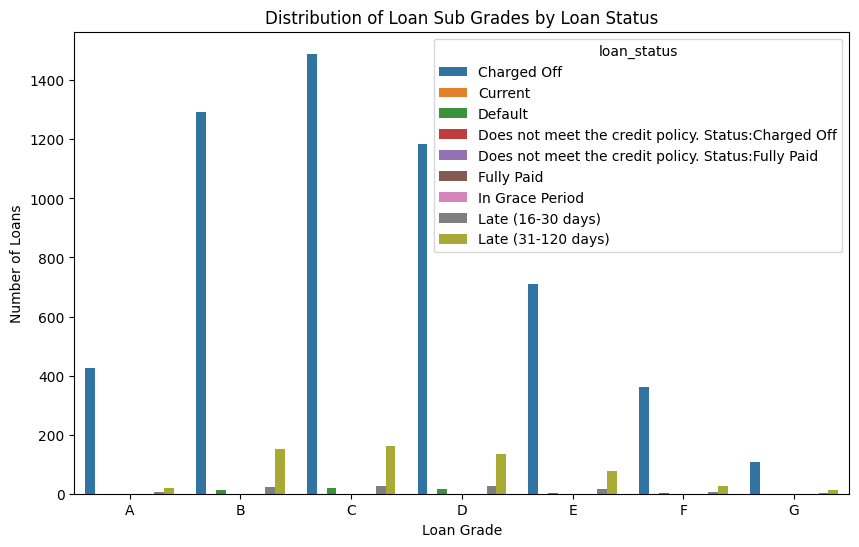

In [16]:
statuses = ["Charged Off", "Late (31-120 days)","Late (16-30 days)", "Default"]
sub_dataframe = insight_dataframe[insight_dataframe["loan_status"].isin(statuses)]

plotter.visualise_loan_grade(sub_dataframe)


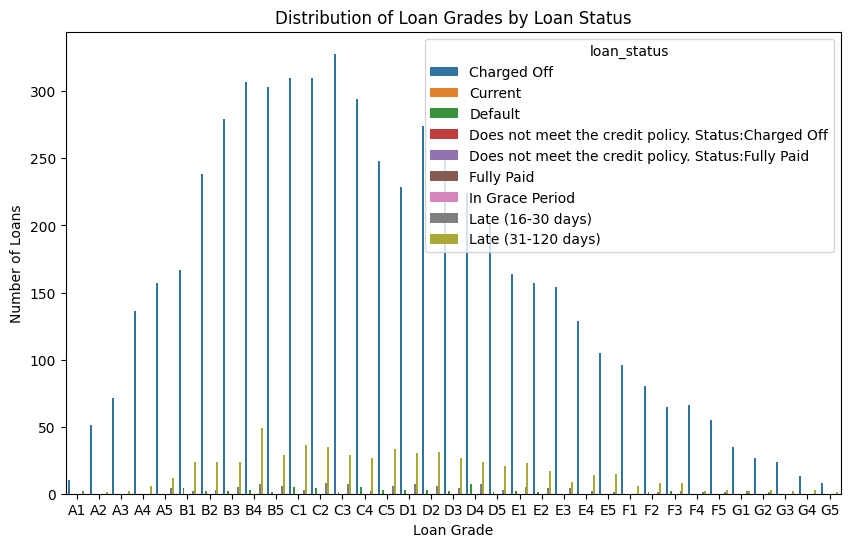

In [17]:
plotter.visualise_loan_subgrade(sub_dataframe)


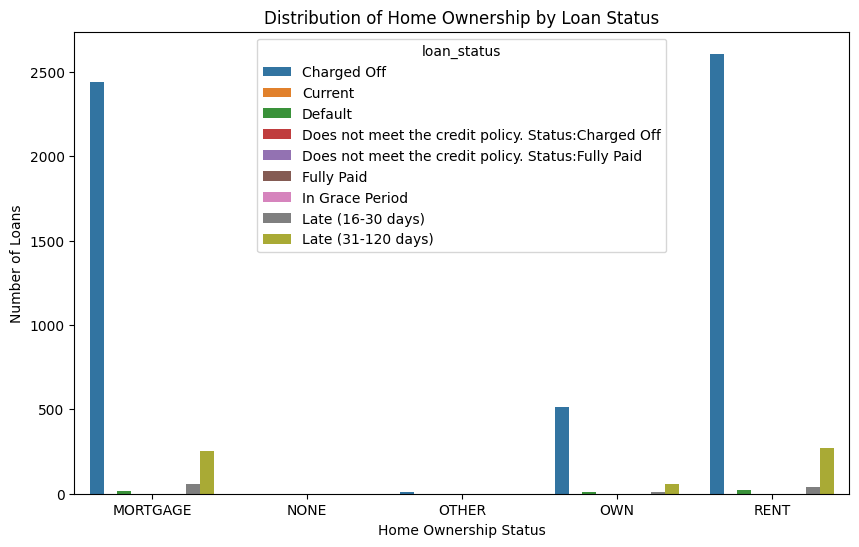

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


In [18]:
plotter.visualise_loan_home(sub_dataframe)

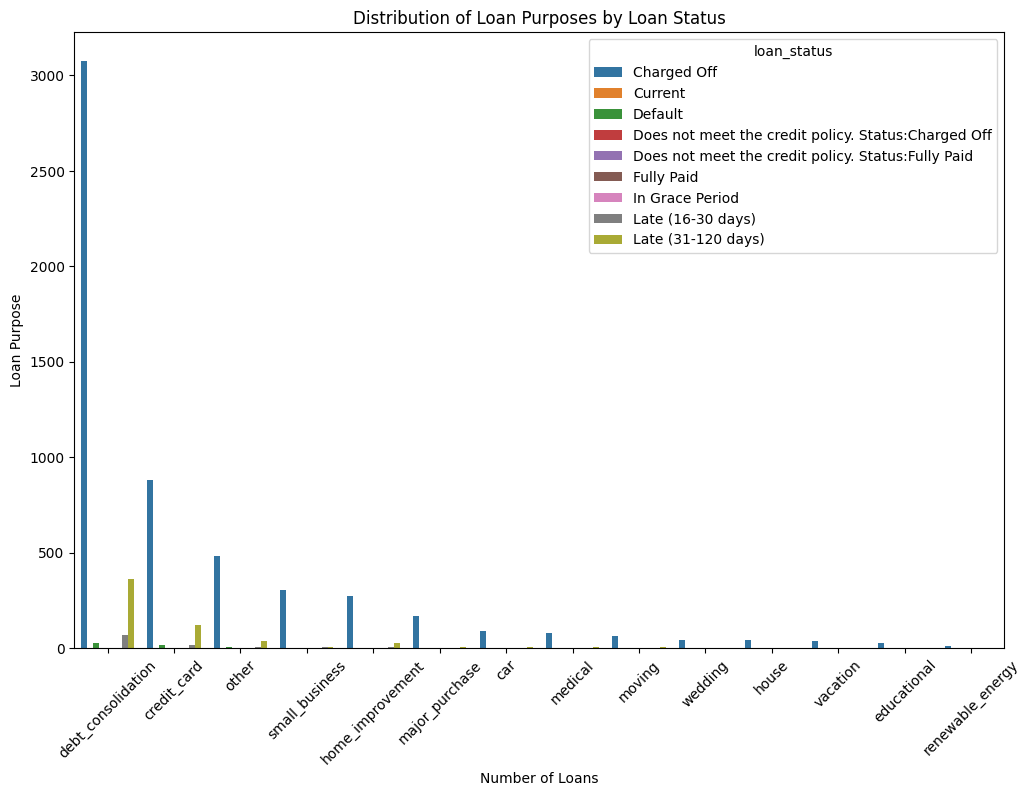

In [19]:
plotter.visualise_loan_purpose(sub_dataframe)


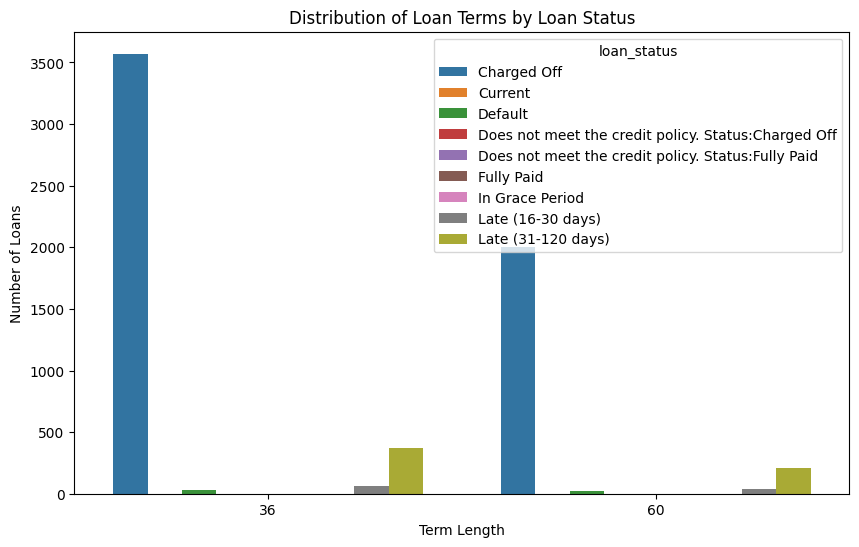

In [20]:
plotter.visualise_loan_term(sub_dataframe)